In [3]:
# 라이브러리

import pandas as pd ; pd.options.display.float_format = '{:.2f}'.format # 소수 둘째자리까지 표시
import numpy as np
import math

import time
from time import sleep
import random
import datetime
from datetime import datetime, timedelta, datetime
import json

from string import ascii_lowercase

import collections
from dateutil.relativedelta import relativedelta

from powernad.API.Campaign import *
from powernad.API.RelKwdStat import *

from urllib.error import HTTPError
import urllib.request

from bs4 import BeautifulSoup
from selenium import webdriver
import psycopg2
import re

from tqdm.notebook import tqdm

import requests; from urllib.parse import urlparse
import seaborn as sns; sns.set(style='darkgrid', font='NanumGothic', font_scale=1.2)
import matplotlib; import matplotlib.pyplot as plt
import squarify

# 구간날짜 변수 생성

In [4]:
"""
날짜 구간 정보가 들어있는 변수들을 생성합니다.
이 변수들을 활용해 날짜 구간을 기준으로 매일 데이터를 갱신합니다.
...
----------------------------------
today = 현재
today = 오늘자 년월일 문자열
yesterday = 어제 
time_week = 7일 전
time_month = 1개월 전
time_year = 1년 전
time_two_years = 2년 전
time_three_years = 3년 전
"날짜구간 변수명"_index = 날짜구간 인덱스
dt_"날짜구간" = 날짜구간 인덱스를 리스트 형태로 
"""

# 오늘
toda = datetime.now()
today = str(datetime.now().date()) # 


# 1일 전
yesterday = toda - relativedelta(days=1)
yesterday = yesterday.strftime('%Y-%m-%d')
yesterday = str(yesterday)


# 1주
time_week = toda - relativedelta(weeks=1)
time_week = time_week.strftime('%Y-%m-%d')
time_week = str(time_week)
# 최근 1주 리스트
week_index = pd.date_range(start=time_week, end= yesterday)
dt_week = week_index.strftime("%Y-%m-%d").tolist()


# 1개월
time_month = toda - relativedelta(months=1)
time_month = time_month.strftime('%Y-%m-%d')
time_month= str(time_month)
# 최근 1개월 리스트
month_index = pd.date_range(start=time_month, end= yesterday)
dt_month = month_index.strftime("%Y-%m-%d").tolist()


# 1년
time_year = toda - relativedelta(years=1)
time_year = time_year.strftime('%Y-%m-%d')
time_year= str(time_year)
# 최근 1년 리스트
year_index = pd.date_range(start=time_year, end= yesterday)
dt_year = year_index.strftime("%Y-%m-%d").tolist()


# 2년
time_two_years = toda - relativedelta(years=2)
time_two_years = time_two_years.strftime('%Y-%m-%d')
time_two_years = str(time_two_years)
# 최근 2년 리스트
two_years_index = pd.date_range(start=time_two_years, end= yesterday)
dt_two_years = two_years_index.strftime("%Y-%m-%d").tolist()

# 3년
time_three_years = toda - relativedelta(years=3)
time_three_years = time_three_years.strftime('%Y-%m-%d')
time_three_years = str(time_three_years)
# 최근 3년 리스트
three_years_index = pd.date_range(start=time_three_years, end= yesterday)
dt_three_years = three_years_index.strftime("%Y-%m-%d").tolist()

In [5]:
# df_origin
"""
네이버 데이터랩 쇼핑인사이트 기준 일자별 가구/인테리어 카테고리 검색랭킹 500위에 포함된 키워드 정보가 있는 데이터프레임입니다.
데이터 시작일 = 2017-08-01
...
rank = 일자별 네이버 데이터랩 검색어 랭킹 (1 ~ 500)
keyword = 검색어 이름
year = 검색어 랭크인한 년도 정보
month = 검색어 랭크인한 월 정보
day = 검색어 랭크인한 일자 정보
ymd = 검색어 랭크인한 당일 년월일 정보
"""
df_origin = pd.read_csv('C:/project/CODE/keyword/data/furniture/naver_top_500/' + yesterday + '_naver_furniture_updated.csv', header = None, encoding='utf-8', index_col=0)
df_origin.columns = ['rank', 'keyword', 'year', 'month', 'day', 'ymd']
df_origin = df_origin.sort_values(by=['ymd', 'rank'])
df_origin = df_origin.reset_index(drop=True)
df_origin

,rank,keyword,year,month,day,ymd
0,1,화장대,2017,8,1,2017-08-01
1,2,책상,2017,8,1,2017-08-01
2,3,쇼파,2017,8,1,2017-08-01
3,4,침대,2017,8,1,2017-08-01
4,5,책장,2017,8,1,2017-08-01
...,...,...,...,...,...,...
772501,495,해바라기그림,2022,6,9,2022-06-09
772502,496,데스커,2022,6,9,2022-06-09
772503,497,마켓비시스템행거,2022,6,9,2022-06-09
772504,498,스위브,2022,6,9,2022-06-09


In [6]:
# df
"""
개별 키워드들의 날짜 정보가 가장 오래된(키워드가 최초 랭크인한 날) 행을 1개만 남기고 나머지 중복값을 모두 삭제한 데이터프레임입니다.
기존에 검색어 랭킹 500위 이내에 없던 키워드가 최초로 랭크된 것은 순간적으로 해당 키워드에 대한 관심도가 증가했다고 볼 수 있습니다.
...
rank = 일자별 네이버 데이터랩 검색어 랭킹 (1 ~ 500)
keyword = 검색어 이름
year = 검색어 랭크인한 년도 정보
month = 검색어 랭크인한 월 정보
day = 검색어 랭크인한 일자 정보
ymd = 검색어 랭크인한 당일 년월일 정보
"""

df = df_origin.drop_duplicates(['keyword'], keep='first')
df = df.reset_index(drop=True)
df

,rank,keyword,year,month,day,ymd
0,1,화장대,2017,8,1,2017-08-01
1,2,책상,2017,8,1,2017-08-01
2,3,쇼파,2017,8,1,2017-08-01
3,4,침대,2017,8,1,2017-08-01
4,5,책장,2017,8,1,2017-08-01
...,...,...,...,...,...,...
5787,400,순면양면누빔베개커버,2022,6,8,2022-06-08
5788,444,네이즌여름매트,2022,6,8,2022-06-08
5789,467,원형메모리폼방석,2022,6,8,2022-06-08
5790,494,접이식토퍼매트리스,2022,6,8,2022-06-08


In [7]:
# df_monthly_keywords
"""
최초등장일이 최근 1개월 이내인 키워드들만 보여주는 데이터프레임입니다.
...
rank = 일자별 네이버 데이터랩 검색어 랭킹 (1 ~ 500)
keyword = 검색어 이름
year = 검색어 랭크인한 년도 정보
month = 검색어 랭크인한 월 정보
day = 검색어 랭크인한 일자 정보
ymd = 검색어 랭크인한 당일 년월일 정보
"""

df_monthly_keywords = df.query('ymd == @dt_month')
df_monthly_keywords = df_monthly_keywords.reset_index(drop=True)

In [8]:
# lis
"""
최초등장일이 최근 1개월 이내인 키워드들이 담긴 리스트를 생성합니다.
"""
lis = list(df_monthly_keywords['keyword'])
len(lis)

303

# 키워드 검색량 조회용 네이버 API

In [9]:
# Naver API 조회용 기본 설정
"""
네이버 광고 API 정보를 조회하기 위한 변수입니다.
...
BASE_URL = 네이버 API 주소
API_KEY = 네이버 검색광고 API 엑세스 라이선스
SECRET_KEY = 네이버 검색광고 API SECRET
CUSTOMER_ID = 네이버 검색광고 API ID
rel = 클라이언트 정보 저장 변수
"""

BASE_URL = 'https://api.naver.com'
API_KEY = '01000000000fcd1ce283f84b5b3f32330368ac6dce35c5a8e3feabf4cfec31ae32b7e9d0e8'
SECRET_KEY = 'AQAAAAAPzRzig/hLWz8yMwNorG3OPks1JGYBp40Ib+rqqydacA=='
CUSTOMER_ID = '2488417'
rel = RelKwdStat(BASE_URL, API_KEY, SECRET_KEY, CUSTOMER_ID)

In [10]:
# search_keyword
def search_keyword(searchword):
    """
    네이버 API 키워드 월간 검색수를 반환해주는 함수입니다.
    ...
    searchword = API 정보를 조회할 키워드명
    """
    
    # kwdDataList = 키워드 검색 정보를 담은 변수입니다.
    kwdDataList = rel.get_rel_kwd_stat_list(siteId=None, biztpId=None, hintKeywords=searchword, event=None, month=None, showDetail='1')

    # kwd_result
    
    '''
    kwdDataList[0].relKeyword = 키워드
    kwdDataList[0].monthlyPcQcCnt = 월간 검색수 (PC)
    kwdDataList[0].monthlyMobileQcCnt = 월간 검색수 (Mobile)
    kwdDataList[0].monthlyPcQcCnt+kwdDataList[0].monthlyMobileQcCnt = 월간 검색수 (total)
    '''
    kwd_result = (kwdDataList[0].relKeyword,
                 kwdDataList[0].monthlyPcQcCnt,
                 kwdDataList[0].monthlyMobileQcCnt,
                 kwdDataList[0].monthlyPcQcCnt+kwdDataList[0].monthlyMobileQcCnt)
    
    # kwd_result[3] = 검색한 키워드명과 월간 pc, 모바일, 총 검색수를 반환합니다
    return(kwd_result[3])

# 네이버 데이터랩 (검색어트렌드) 클라이언트 정보
'''
client_id = 네이버 데이터랩 (검색어트렌드) id
client_secret = 네이버 데이터랩 (검색어트렌드) secret
'''
client_id = "TRmG3krL6bQfGA7X0DZR"  
client_secret = "DR43cO6K2Z"  

In [11]:
# 키워드별 검색량 저장용 자료구조 생성
'''
dictionary_yester = 전일 키워드 검색량 / 딕셔너리
dictionary_now = 오늘자 키워드 검색량  / 딕셔너리
error = 에러 확인 / 리스트
df_total = 일자별 키워드 검색량 / 데이터프레임
'''
dictionary_yester={}
dictionary_now={}
error=[]
df_total = pd.DataFrame(columns=['키워드', '날짜', '수집날짜', '검색량'])


In [12]:
# serach_query
def search_query(list_name):
    """
    위에서 선언한 search_keyword() 함수를 통해 각 키워드의 월간 총 검색량을 추출한 후, 
    날짜별 검색량으로 전환한 데이터프레임을 생성하는 함수입니다.
    ...
    list_name = 조회하고 싶은 키워드 정보가 들어있는 리스트 이름
    """
    
    global df_total
    for i in tqdm(list_name):  
        print(i)
        sleep(1)
        try:
            if type(search_keyword(i)) !=str : 
                searchword = i.replace(" ","")
                a = search_keyword(searchword)


                url = "https://openapi.naver.com/v1/datalab/search"
                body = "{\"startDate\":\""+time_month+"\",\"endDate\":\""+today+"\",\"timeUnit\":\"date\",\"keywordGroups\":[{\"groupName\":\""+i+"\",\"keywords\":[\""+i+"\"]}]}";
                requested = urllib.request.Request(url)
                requested.add_header("X-Naver-Client-Id", client_id)
                requested.add_header("X-Naver-Client-Secret", client_secret)
                requested.add_header("Content-Type", "application/json")
                response = urllib.request.urlopen(requested, data=body.encode("utf-8"))
                rescode = response.getcode()

                if(rescode==200):
                    response_body = response.read()
                    output_data = response_body.decode('utf-8')
                else:
                    print('Error code:'+ rescode)
                    pass

                # result = API 조회 결과값이 들어있는 변수입니다.
                result = json.loads(output_data)

                # date = a['period'] 에서 최근 1개월간의 날짜 값들을 추출한 리스트를 생성합니다.
                date = [a['period'] for a in result['results'][0]['data']]

                # aa = 날짜와 날짜별 검색량을 추출한 데이터프레임을 생성합니다.
                aa = pd.DataFrame({'date':date, 
                              'querycount':[a['ratio'] for a in result['results'][0]['data']],
                              })

                # 일일 데이터 계산 
                sleep(0.5)
                total = aa['querycount'].sum() 
                
                # 30일간 모든 백분율 값을 더한 후 일자별 실제 검색량을 반환합니다.
                '''
                total = 날짜별 모든 백분율 검색량을 더한 값
                float(a) = 월간 총 검색량 실수화
                x = 각 일자별 검색량
                '''
                aa['검색량'] = aa['querycount'].apply(lambda x :((x / total)*float(a)))


            else : 
                pass

        except (TypeError, IndexError,KeyError,ValueError):
            print(" 타입 or 인덱스 에러,Value 에러:",i)
            error.append(i)
            pass


        except HTTPError:
            print('http 에러:', i )
            error.append(i)
            pass

            #여기부터 새로 코딩
        try: 
            if type(search_keyword(i)) !=str : 
                searchword = i.replace(" ","")
                a = search_keyword(searchword)        


                date = pd.DataFrame(data=dt_month, columns=['날짜'])

                spred = pd.merge(date,aa,left_on='날짜',right_on='date',how='outer')
                spred.drop(['date'],inplace=True, axis=1)

                spred.replace(np.nan,0,inplace=True)


                a=[] 

                for j in range(len(spred)) : 
                    a.append(today)


                spred['수집날짜'] = a
                spred['키워드'] = i
                spred = spred[['키워드', '날짜','수집날짜', '검색량']]

                if i in dictionary_yester:

                    pass

                else : 
                    dictionary_yester[i]=[]



                dictionary_now[i]=spred
                df_total = pd.concat([df_total, spred])

            else:
                pass

        except (TypeError, IndexError,KeyError,ValueError):

            pass

        sleep(0.5)
        try :
            if type(search_keyword(i)) !=str : 
                searchword = i.replace(" ","")
                a = search_keyword(searchword)        

                if dictionary_yester[i]==[]:
                    dictionary_yester[i] = dictionary_now[i]

                else : 
                    pass 
            else:
                pass


        except (TypeError, IndexError,KeyError):
              pass


        except ValueError:


                yester_df= dictionary_yester[i]
                today_df = dictionary_now[i]


                yester_df.set_index('날짜',inplace=True)

                today_df.set_index('날짜',inplace=True)

                yester_df.update(today_df)


                tmpt = today_df.iloc[-1,:]

                yester_df = yester_df.append(tmpt)

                yester_df.reset_index(inplace=True)
                today_df.reset_index(inplace=True)


                dictionary_yester[i] = yester_df

#             df_total = pd.concat([df_total, spred])

        except :
            print('API 에러',i)
            error.append(i)



        sleep(3)

    df_total['검색량'] = df_total['검색량'].astype(int)
    
    df_total.to_csv('C:/project/CODE/keyword/data/furniture/query/' + yesterday + '_month_furniture_query_by_date.csv', encoding='UTF-8')
    
    return(df_total)

In [13]:
search_query(lis)

  0%|          | 0/303 [00:00<?, ?it/s]

규조토발매트소형
 타입 or 인덱스 에러,Value 에러: 규조토발매트소형
헤링본규조토발매트
큐빅스사이드테이블쇼파
사라사라여름쿨매트
무볼트앵글수납선반선반장
 타입 or 인덱스 에러,Value 에러: 무볼트앵글수납선반선반장
방수가죽식탁매트
빨아쓰는규조토
욕실규조토
침대협탁사이드
 타입 or 인덱스 에러,Value 에러: 침대협탁사이드
수납선반모듈선반팬트리
 타입 or 인덱스 에러,Value 에러: 수납선반모듈선반팬트리
마켓비주방수납장
마켓비2문수납장
 타입 or 인덱스 에러,Value 에러: 마켓비2문수납장
방수매트
마켓비미니수납장
욕실규조토발매트
삼나무원목책상
 타입 or 인덱스 에러,Value 에러: 삼나무원목책상
로렌책상
마켓비옷장
페이퍼인센스
옷서랍장
허리베개
론체어
슈퍼싱글매트리스추천
실내용디퓨저byldf001천연디퓨저
 타입 or 인덱스 에러,Value 에러: 실내용디퓨저byldf001천연디퓨저
천연디퓨저실내용디퓨저byldf001
 타입 or 인덱스 에러,Value 에러: 천연디퓨저실내용디퓨저byldf001
헤링본여름쿨매트
 타입 or 인덱스 에러,Value 에러: 헤링본여름쿨매트
천연디퓨저디퓨저byldf001실내용
 타입 or 인덱스 에러,Value 에러: 천연디퓨저디퓨저byldf001실내용
실내용byldf001천연디퓨저디퓨저
 타입 or 인덱스 에러,Value 에러: 실내용byldf001천연디퓨저디퓨저
천연디퓨저디퓨저실내용byldf001
 타입 or 인덱스 에러,Value 에러: 천연디퓨저디퓨저실내용byldf001
실내용byldf001디퓨저천연디퓨저
 타입 or 인덱스 에러,Value 에러: 실내용byldf001디퓨저천연디퓨저
실내용천연디퓨저byldf001디퓨저
 타입 or 인덱스 에러,Value 에러: 실내용천연디퓨저byldf001디퓨저
쪽가위
실내용천연디퓨저디퓨저byldf001
 타입 or 인덱스 에러,Value 에러: 실내용천연디퓨저디퓨저byldf001
마켓비원목선반
 타입 or 인덱스 에러,Value 에러: 마켓비원목선반
소음재
모래멍
책상

,키워드,날짜,수집날짜,검색량
0,헤링본규조토발매트,2022-05-10,2022-06-10,57
1,헤링본규조토발매트,2022-05-11,2022-06-10,43
2,헤링본규조토발매트,2022-05-12,2022-06-10,40
3,헤링본규조토발매트,2022-05-13,2022-06-10,45
4,헤링본규조토발매트,2022-05-14,2022-06-10,35
...,...,...,...,...
26,접이식토퍼매트리스,2022-06-05,2022-06-10,291
27,접이식토퍼매트리스,2022-06-06,2022-06-10,284
28,접이식토퍼매트리스,2022-06-07,2022-06-10,304
29,접이식토퍼매트리스,2022-06-08,2022-06-10,319


In [14]:
# df_query
"""
네이버 패션의류 탑 500 에 신규진입한 키워드의 최근 1개월 동안의 일자별 검색량이 있는 데이터프레임입니다.
"""
df_query = df_total
df_query = df_query[['키워드', '날짜', '수집날짜', '검색량']]
df_query = df_query.rename(columns={'키워드':'keyword', '날짜':'ymd', '수집날짜':'search_date', '검색량': 'query'})
df_query['query'] = df_query['query'].astype(int)
df_query

,keyword,ymd,search_date,query
0,헤링본규조토발매트,2022-05-10,2022-06-10,57
1,헤링본규조토발매트,2022-05-11,2022-06-10,43
2,헤링본규조토발매트,2022-05-12,2022-06-10,40
3,헤링본규조토발매트,2022-05-13,2022-06-10,45
4,헤링본규조토발매트,2022-05-14,2022-06-10,35
...,...,...,...,...
26,접이식토퍼매트리스,2022-06-05,2022-06-10,291
27,접이식토퍼매트리스,2022-06-06,2022-06-10,284
28,접이식토퍼매트리스,2022-06-07,2022-06-10,304
29,접이식토퍼매트리스,2022-06-08,2022-06-10,319


In [15]:
# df_query_sum
"""
신규키워드들의 최근 1개월 누적 검색량이 있는 데이터프레임입니다.
"""
df_query_sum = df_query[['keyword', 'query']].groupby('keyword').sum()
df_query_sum = df_query_sum.rename(columns = {'query':'query_month'})
df_query_sum.sort_values('query_month', ascending=False)

,query_month
keyword,
장미맨숀,242385
지컷원피스,50832
린넨,50136
화사거울,36575
에몬스,32447
...,...
가꿈스튜디오,68
소음재,60
여름이불60수,59


In [16]:
# df_query_m
"""
최근 1개월 이내에 키워드 검색 탑 500에 등장한 키워드들의 검색량을 보여주는 데이터프레임입니다.
...
query = 신규 키워드 랭크 진입 당일 검색량
query_month = 신규 키워드의 최근 1개월 누적 검색량
"""

df_query_m = pd.merge(df_monthly_keywords, df_query, on='keyword')
df_query_m = pd.merge(df_query_m, df_query_sum, on = 'keyword')
df_query_m = df_query_m[df_query_m['ymd_x'] == df_query_m['ymd_y']]
df_query_m = df_query_m.drop(['ymd_y'], axis=1).sort_values(['ymd_x', 'rank'])
df_query_m.rename(columns = {'ymd_x':'ymd'},inplace=True)
df_query_m.reset_index(inplace=True, drop=True)

df_query_m

,rank,keyword,year,month,day,ymd,search_date,query,query_month
0,133,헤링본규조토발매트,2022,5,10,2022-05-10,2022-06-10,57,335
1,470,방수가죽식탁매트,2022,5,10,2022-05-10,2022-06-10,322,3294
2,53,빨아쓰는규조토,2022,5,11,2022-05-11,2022-06-10,75,2669
3,54,욕실규조토,2022,5,11,2022-05-11,2022-06-10,29,314
4,279,마켓비주방수납장,2022,5,11,2022-05-11,2022-06-10,19,153
...,...,...,...,...,...,...,...,...,...
156,331,코지블,2022,6,8,2022-06-08,2022-06-10,0,30
157,340,모찌,2022,6,8,2022-06-08,2022-06-10,386,11535
158,400,순면양면누빔베개커버,2022,6,8,2022-06-08,2022-06-10,332,1883
159,444,네이즌여름매트,2022,6,8,2022-06-08,2022-06-10,471,1656


In [17]:
# df_m
"""
최근 1개월 이내 키워드 검색 탑 500 에 등장한 키워드 정보가 담겨있는 데이터프레임입니다.
"""
df_m = pd.DataFrame({'등장일자':df_query_m['ymd'], '랭킹':df_query_m['rank'], '키워드':df_query_m['keyword'], '일간검색량':df_query_m['query'], '월간검색량':df_query_m['query_month']})
df_m.to_csv('C:/project/CODE/keyword/data/furniture/output/' + yesterday + '_trendy_furniture_keywords.csv', encoding='UTF-8')
df_m

,등장일자,랭킹,키워드,일간검색량,월간검색량
0,2022-05-10,133,헤링본규조토발매트,57,335
1,2022-05-10,470,방수가죽식탁매트,322,3294
2,2022-05-11,53,빨아쓰는규조토,75,2669
3,2022-05-11,54,욕실규조토,29,314
4,2022-05-11,279,마켓비주방수납장,19,153
...,...,...,...,...,...
156,2022-06-08,331,코지블,0,30
157,2022-06-08,340,모찌,386,11535
158,2022-06-08,400,순면양면누빔베개커버,332,1883
159,2022-06-08,444,네이즌여름매트,471,1656


In [18]:
# keyword_grouping

splitted_list = [['소파']] # splitted_list = 기준 키워드
def keyword_grouping(list_name):
    """
    키워드의 장기간 검색량을 일자별로 수집하는 함수입니다.
    네이버 API는 한번에 5개까지만 키워드를 조회할 수 있는데, 한 번에 5개 이상의 키워드 검색량 정보를 조회합니다.
    단, 네이버 API 를 통해 최근 1개월보다 이전의 검색량을 조회할 경우, 
    검색된 키워드의 검색량이 아니라 조회한 키워드 중 검색량이 가장 많았던 시점을 기준으로 0 ~ 100 사이의 백분율 정보를 제공합니다.
    각 키워드의 실제 검색량이 달라도 같은 100으로 집계되는 경우를 방지하기 위해 5개의 그룹에 항상 포함되는 기준 키워드를 설정했습니다.
    ex)
    ['운동화', 'A', 'B', 'C', 'D']
    ['운동화', 'E', 'F', 'G', 'H']
    ...
    list_name = 조회할 키워드가 들어있는 리스트명
    """

    # 키워드가 5개씩 순차적으로 들어있는 2차원 리스트 생성 반복문
    # 마지막 리스트가 5개로 떨어지지 않을 경우 '더미' 를 채워서 5개를 완성합니다.
    for i in range(0, len(list_name), 4):
        y = []
        if i <= len(list_name) - 4:
            y = [list_name[i], list_name[i+1], list_name[i+2], list_name[i+3]]
            splitted_list.append(y)
        elif i == len(list_name) - 3:
            y = [list_name[i], list_name[i+1], list_name[i+2], '더미']
            splitted_list.append(y)
        elif i == len(list_name) - 2:
            y = [list_name[i], list_name[i+1], '더미', '더미']
            splitted_list.append(y)
        else:
            y = [list_name[i], '더미', '더미', '더미']
            splitted_list.append(y)  

    i = 1
    
    return splitted_list

In [19]:
keyword_grouping(lis)

[['소파'],
 ['규조토발매트소형', '헤링본규조토발매트', '큐빅스사이드테이블쇼파', '사라사라여름쿨매트'],
 ['무볼트앵글수납선반선반장', '방수가죽식탁매트', '빨아쓰는규조토', '욕실규조토'],
 ['침대협탁사이드', '수납선반모듈선반팬트리', '마켓비주방수납장', '마켓비2문수납장'],
 ['방수매트', '마켓비미니수납장', '욕실규조토발매트', '삼나무원목책상'],
 ['로렌책상', '마켓비옷장', '페이퍼인센스', '옷서랍장'],
 ['허리베개', '론체어', '슈퍼싱글매트리스추천', '실내용디퓨저byldf001천연디퓨저'],
 ['천연디퓨저실내용디퓨저byldf001',
  '헤링본여름쿨매트',
  '천연디퓨저디퓨저byldf001실내용',
  '실내용byldf001천연디퓨저디퓨저'],
 ['천연디퓨저디퓨저실내용byldf001', '실내용byldf001디퓨저천연디퓨저', '실내용천연디퓨저byldf001디퓨저', '쪽가위'],
 ['실내용천연디퓨저디퓨저byldf001', '마켓비원목선반', '소음재', '모래멍'],
 ['책상컴퓨터의자', '양면암막커튼', '학생책상의자', '메트로캔들워머'],
 ['릴리4인용세라믹식탁', '컴퓨터학생의자', '빨아쓰는발매트', '헬시메이트블랙라벨기능성메모리폼경추베개'],
 ['오에스퍼니처osg100컴퓨터게이밍의자', '원목4인식탁세트벤치+의자형', '장미맨숀', '전자렌지밥솥오븐수납장선반'],
 ['전자레인지밥솥오븐선반수납장600', '사무용책상의자', '실내용디퓨저', '실내용천연디퓨저'],
 ['무볼트앵글', '모던티비다이', '데코지오쉐도우아일렛형암막커튼일반커튼방한커튼가리개커튼', '편백깔판'],
 ['르올바디필로우', '실내분수', '우드행거', '원목침대프레임ss'],
 ['투에이치몰슈퍼싱글이불', '헤링본쿨매트', '시스템행거2단행거', '여름이불60수'],
 ['태양열조명', '컴피플러피60수순면피그먼트패드라지킹이스턴킹', '방수베개커버', '릴리즈철제캔들홀더촛불양초티라이트받침'],
 ['선인장소품

In [20]:
# datalab_api
def datalab_api(keywords):
    """
    네이버 데이터랩 API를 활용해 입력된 키워드의 최근 3년간 일자별 검색량을 조회하는 함수입니다.
    ...
    list_name = 검색량을 조회하고자 하는 키워드
    """
    
    # 데이터랩 API 계정 및 url 정보
    client_id = "kJG1RgASjzoPJ2bpUq8L"    
    client_secret = "LBYXkCdlRf"
    url = "https://openapi.naver.com/v1/datalab/search"
    
    # 조회 조건 설정
    '''
    startdate = 검색량 조회 시작일자
    enddate = 검색량 조회 종료일자
    timeunit = 검색량 수집 기준
    keywordgroups = 조회를 원하는 키워드 그룹
    '''
    body = {
        "startDate":time_three_years,
        "endDate":yesterday,
        "timeUnit":"date",
        "keywordGroups":[
            {"groupName":str(keywords[0]),"keywords":[str(keywords[0])]},
            {"groupName":str(keywords[1]),"keywords":[str(keywords[1])]},
            {"groupName":str(keywords[2]),"keywords":[str(keywords[2])]},
            {"groupName":str(keywords[3]),"keywords":[str(keywords[3])]},
            {"groupName":str(keywords[4]),"keywords":[str(keywords[4])]},
        ],
    }
    
    # 검색량 조회 결과값이 들어있는 딕셔너리 변수
    body = json.dumps(body)
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-id", client_id)
    request.add_header("X-Naver-Client-Secret", client_secret)
    request.add_header("Content-Type", "application/json")
    response = urllib.request.urlopen(request, data=body.encode("utf-8"))
    json_obj = json.loads(response.read().decode('utf-8'))

    # 조회한 5개의 키워드 검색량을 각각의 데이터프레임에 저장
    df1 = pd.DataFrame(json_obj['results'][0]['data'])
    df2 = pd.DataFrame(json_obj['results'][1]['data'])
    df3 = pd.DataFrame(json_obj['results'][2]['data'])
    df4 = pd.DataFrame(json_obj['results'][3]['data'])
    df5 = pd.DataFrame(json_obj['results'][4]['data'])

    
    
    # 딕셔너리 안에 조회 결과가 들어있지 않아서 데이터프레임을 생성하지 못할 시 오류가 발생하는 경우를 방지하기 위한 반복문
    # 데이터프레임 생성에 실패한 경우 값이 0으로 채워진 데이터프레임을 생성
    df_list = [df1,df2,df3,df4,df5]
    for i in tqdm(range(len(df_list))):
        if len(list(df_list[i].columns)) ==2:
            df_list[i].columns=['기간', str(keywords[i])]
        elif len(list(df_list[i].columns)) ==0:
            df_list[i]['기간'] = 0
            df_list[i][str(keywords[i])] = 0

    # 5개의 키워드 검색량 데이터프레임 병합
    df2 = df1.merge(df2, how='outer', on='기간').fillna(0)
    df3 = df2.merge(df3, how='outer', on='기간').fillna(0)
    df4 = df3.merge(df4, how='outer', on='기간').fillna(0)
    df5 = df4.merge(df5, how='outer', on='기간').fillna(0)

    return df5


In [21]:
# df_api
"""
기준 키워드(소파)의 검색량 최소값과 최대값을 구해서 상대치를 갱신하는 정규화입니다.
"""
df_api = datalab_api(splitted_list[0] + splitted_list[1])
a, b = df_api.iloc[:,1].min(), df_api.iloc[:,1].max()
print('기준 키워드(소파) 검색량 최소값: ' + format(a, ".5f") + ', 최대값' + format(b, ".5f"))

  0%|          | 0/5 [00:00<?, ?it/s]

기준 키워드(소파) 검색량 최소값: 33.20079, 최대값100.00000


In [22]:
# datalab_api_keylist
def datalab_api_keylist(list_name):
    """
    기준 키워드를 기준으로 최소-최대 정규화를 적용한 데이터랩 검색량을 추출하는 함수입니다.
    ...
    list_name = 기준 키워드와 검색량을 조회할 키워드들이 들어있는 2차원 리스트
    """
    
    # df_api
    # 기준 키워드(침대)의 검색량 최소값과 최대값을 구하는 정규화 작업으로 키워드별 실제 검색량의 상대치를 보정합니다.
    df_api = datalab_api(list_name[0]+list_name[1])
    a, b = df_api.iloc[:,1].min(), df_api.iloc[:,1].max()
    print('기준 키워드(침대) 검색량 최소값: ' + format(a, ".5f") + ', 최대값' + format(b, ".5f"), '\n')
    
    i = 2
    while i < len(list_name):
        try:
            df1 = datalab_api(list_name[0]+list_name[i])
            x, y = df1.iloc[:,1].min(), df1.iloc[:,1].max()    

            # df1 = 기준 키워드 검색량의 최소-최대 정규화
            df1.iloc[:,2] = (df1.iloc[:,2] -x) / (y - x) * (b - a) + a
            df1.iloc[:,3] = (df1.iloc[:,3] -x) / (y - x) * (b - a) + a
            df1.iloc[:,4] = (df1.iloc[:,4] -x) / (y - x) * (b - a) + a
            df1.iloc[:,5] = (df1.iloc[:,5] -x) / (y - x) * (b - a) + a
            df1 = df1.drop(columns=['기간', '소파'])
            df_api = pd.concat([df_api, df1], axis=1)

            
            i+=1
        
            time.sleep( random.uniform(2,4) )
        
        except IndexError:
            pass
        
        print('작업 진행률: ' + format(i / len(splitted_list), ".2f"))

    # 더미 키워드 삭제 및 저장
    df_api = df_api[df_api.columns.drop(list(df_api.filter(regex='더미')))]
    df_api.to_csv('C:/project/CODE/keyword/data/furniture/query/' + yesterday + '_three_years_furniture_query.csv', encoding='UTF-8')

    # 
    return df_api

In [23]:
datalab_api_keylist(splitted_list)

  0%|          | 0/5 [00:00<?, ?it/s]

기준 키워드(침대) 검색량 최소값: 33.20079, 최대값100.00000 



  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.04


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.05


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.06


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.08


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.09


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.10


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.12


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.13


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.14


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.16


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.17


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.18


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.19


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.21


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.22


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.23


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.25


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.26


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.27


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.29


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.30


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.31


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.32


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.34


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.35


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.36


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.38


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.39


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.40


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.42


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.43


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.44


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.45


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.47


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.48


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.49


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.51


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.52


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.53


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.55


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.56


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.57


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.58


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.60


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.61


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.62


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.64


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.65


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.66


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.68


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.69


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.70


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.71


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.73


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.74


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.75


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.77


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.78


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.79


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.81


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.82


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.83


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.84


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.86


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.87


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.88


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.90


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.91


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.92


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.94


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.95


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.96


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.97


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.99


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 1.00


,기간,소파,규조토발매트소형,헤링본규조토발매트,큐빅스사이드테이블쇼파,사라사라여름쿨매트,무볼트앵글수납선반선반장,방수가죽식탁매트,빨아쓰는규조토,욕실규조토,...,코지블,모찌,롱쿠션긴베개,큰안고자는베개,쿠션u자형,순면양면누빔베개커버,네이즌여름매트,원형메모리폼방석,접이식토퍼매트리스,편백메모리폼베개휴레카
0,2019-06-10,42.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,7.81,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2019-06-11,38.26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,7.52,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2019-06-12,37.85,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,7.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,2019-06-13,36.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,7.94,0.00,0.00,0.00,0.00,0.00,0.00,0.09,0.00
4,2019-06-14,34.78,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,8.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2022-06-05,57.20,0.00,0.00,0.00,0.00,0.00,0.00,1.41,0.12,...,0.08,6.22,1.44,0.00,0.00,0.00,0.00,0.00,4.71,0.86
1092,2022-06-06,61.29,0.00,0.00,0.00,0.00,0.00,0.00,1.68,0.09,...,0.00,6.33,1.38,0.00,0.00,0.00,0.00,0.08,4.59,6.03
1093,2022-06-07,48.62,0.00,0.00,0.00,0.00,0.00,0.83,1.45,0.14,...,0.00,5.34,1.35,0.00,0.00,0.20,5.70,0.00,4.91,6.35
1094,2022-06-08,48.10,0.00,0.00,0.00,0.00,0.00,1.85,1.70,0.20,...,0.00,5.99,1.41,0.00,0.00,5.57,7.16,0.00,5.15,6.96


# 키워드 검색량 시각화

In [ ]:
"""
시각화에 필요한 데이터프레임 목록
...
df_m : 최종적으로 스트림릿에 들어갈 데이터프레임 ; 키워드 랭크인 당시 날짜정보, 당일 검색량, 30일 이내 누적 검색량 정보
df_vis : 최근 3년 동안의 날짜별 키워드 검색량이 있는 데이터프레임 ; 년월일, 날짜별 키워드 검색량
df_ym : 키워드의 년월 검색량 추이 시각화에 활용할 데이터프레임 ; 년도와 월을 2중 인덱스로 설정, 검색량 정보는 월평균으로 변환

"""

In [24]:
# df_vis
"""
최근 1개월 이내 탑 500 키워드에 진입한 키워드들의 일자별 검색량 정보가 있는 데이터프레임입니다.
시작날짜 = 2019-06(3년전)
종료날짜 = 1일전
데이터프레임의 '기간' 컬럼을 datetime 자료형으로 변경한 후 년, 월, 일 컬럼을 추가합니다.
"""
df_vis = pd.read_csv('C:/project/CODE/keyword/data/furniture/query/'+ yesterday + '_three_years_furniture_query.csv', encoding='UTF-8', index_col=0)
df_vis['기간']= pd.to_datetime(df_vis['기간'])
df_vis['year'] = df_vis['기간'].dt.year
df_vis['month'] = df_vis['기간'].dt.month
df_vis['date'] = df_vis['기간'].dt.date
df_vis = df_vis.set_index('기간') # 년월일을 인덱스로 지정
df_vis

,소파,규조토발매트소형,헤링본규조토발매트,큐빅스사이드테이블쇼파,사라사라여름쿨매트,무볼트앵글수납선반선반장,방수가죽식탁매트,빨아쓰는규조토,욕실규조토,침대협탁사이드,...,큰안고자는베개,쿠션u자형,순면양면누빔베개커버,네이즌여름매트,원형메모리폼방석,접이식토퍼매트리스,편백메모리폼베개휴레카,year,month,date
기간,,,,,,,,,,,,,,,,,,,,,
2019-06-10,42.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2019,6,2019-06-10
2019-06-11,38.26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2019,6,2019-06-11
2019-06-12,37.85,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2019,6,2019-06-12
2019-06-13,36.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.09,0.00,2019,6,2019-06-13
2019-06-14,34.78,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2019,6,2019-06-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-05,57.20,0.00,0.00,0.00,0.00,0.00,0.00,1.41,0.12,0.00,...,0.00,0.00,0.00,0.00,0.00,4.71,0.86,2022,6,2022-06-05
2022-06-06,61.29,0.00,0.00,0.00,0.00,0.00,0.00,1.68,0.09,0.00,...,0.00,0.00,0.00,0.00,0.08,4.59,6.03,2022,6,2022-06-06
2022-06-07,48.62,0.00,0.00,0.00,0.00,0.00,0.83,1.45,0.14,0.00,...,0.00,0.00,0.20,5.70,0.00,4.91,6.35,2022,6,2022-06-07


In [25]:
# 키워드를 연도별로 그룹화해서 각각의 연평균 검색량을 조회
df_vis.groupby(df_vis.index.year).mean()

,소파,규조토발매트소형,헤링본규조토발매트,큐빅스사이드테이블쇼파,사라사라여름쿨매트,무볼트앵글수납선반선반장,방수가죽식탁매트,빨아쓰는규조토,욕실규조토,침대협탁사이드,...,롱쿠션긴베개,큰안고자는베개,쿠션u자형,순면양면누빔베개커버,네이즌여름매트,원형메모리폼방석,접이식토퍼매트리스,편백메모리폼베개휴레카,year,month
기간,,,,,,,,,,,,,,,,,,,,,
2019,44.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00,2019.00,9.14
2020,63.94,0.00,0.01,0.00,0.00,0.00,0.00,0.46,0.12,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.24,0.00,2020.00,6.51
2021,62.11,0.00,0.00,0.00,0.00,0.00,0.00,0.44,0.08,0.00,...,0.11,0.00,0.00,0.00,0.00,0.01,0.76,0.00,2021.00,6.53
2022,55.64,0.09,0.05,0.01,0.10,0.20,0.84,1.10,0.24,0.01,...,0.05,0.00,0.00,0.39,0.16,0.02,1.43,0.18,2022.00,3.18


In [26]:
# 키워드를 연도별로 그룹화해서 각각의 전년대비 평균 검색량 변화율을 조회
df_vis.groupby(df_vis.index.year).mean().pct_change()

,소파,규조토발매트소형,헤링본규조토발매트,큐빅스사이드테이블쇼파,사라사라여름쿨매트,무볼트앵글수납선반선반장,방수가죽식탁매트,빨아쓰는규조토,욕실규조토,침대협탁사이드,...,롱쿠션긴베개,큰안고자는베개,쿠션u자형,순면양면누빔베개커버,네이즌여름매트,원형메모리폼방석,접이식토퍼매트리스,편백메모리폼베개휴레카,year,month
기간,,,,,,,,,,,,,,,,,,,,,
2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020,0.43,-1.00,2.49,NaN,NaN,NaN,inf,inf,6.23,NaN,...,NaN,NaN,NaN,NaN,NaN,0.45,5.73,NaN,0.00,-0.29
2021,-0.03,inf,-0.94,NaN,NaN,NaN,1.16,-0.03,-0.32,NaN,...,inf,NaN,NaN,NaN,NaN,1.34,2.18,NaN,0.00,0.00
2022,-0.10,81.86,126.30,inf,inf,inf,289.62,1.49,2.02,inf,...,-0.56,NaN,NaN,inf,inf,0.58,0.89,inf,0.00,-0.51


In [27]:
# df_ym
# 연도와 월을 인덱스로 지정한 후 키워드 검색량을 연월로 그룹화해서 연월별 평균 검색량을 조회합니다.
df_vis['year'] = df_vis.index.year; df_vis['month'] = df_vis.index.month
df_ym = df_vis.groupby([df_vis.index.year, df_vis.index.month]).mean()
df_ym

소파  규조토발매트소형  헤링본규조토발매트  큐빅스사이드테이블쇼파  사라사라여름쿨매트  무볼트앵글수납선반선반장  \
기간   기간                                                                    
2019 6  39.94      0.00       0.00         0.00       0.00          0.00   
     7  41.24      0.00       0.00         0.00       0.00          0.00   
     8  43.70      0.00       0.00         0.00       0.00          0.00   
     9  44.28      0.00       0.00         0.00       0.00          0.00   
     10 45.92      0.00       0.00         0.00       0.00          0.00   
     11 47.59      0.00       0.01         0.00       0.00          0.00   
     12 49.09      0.00       0.00         0.00       0.00          0.00   
2020 1  53.16      0.00       0.00         0.00       0.00          0.00   
     2  62.84      0.00       0.03         0.00       0.00          0.00   
     3  68.50      0.00       0.01         0.00       0.00          0.00   
     4  71.52      0.00       0.01         0.00       0.00          0.00   
     5  64.58      0.00       0.01         0.00       0.00          0.00   
     6  58.76      0.00       0.01         0.00       0.00          0.00   
     7  59.42      0.00       0.01         0.00       0.00          0.00   
     8  65.87      0.00       0.00         0.00       0.00          0.00   
     9  67.43      0.00       0.01         0.00       0.00          0.00   
     10 62.80      0.00       0.00         0.00       0.00          0.00   
     11 63.29      0.00       0.00         0.00       0.00          0.00   
     12 69.18      0.00       0.00         0.00       0.00          0.00   
2021 1  71.49      0.00       0.00         0.00       0.00          0.00   
     2  66.85      0.00       0.00         0.00       0.00          0.00   
     3  62.68      0.00       0.00         0.00       0.00          0.00   
     4  59.24      0.00       0.00         0.00       0.00          0.00   
     5  57.83      0.00       0.00         0.00       0.00          0.00   
     6  56.74      0.00       0.00         0.00       0.00          0.00   
     7  58.39      0.00       0.00         0.00       0.00          0.00   
     8  67.37      0.00       0.00         0.00       0.00          0.00   
     9  67.97      0.00       0.00         0.00       0.00          0.00   
     10 68.04      0.00       0.00         0.00       0.00          0.00   
     11 57.17      0.00       0.00         0.00       0.00          0.00   
     12 51.77      0.00       0.00         0.00       0.00          0.00   
2022 1  57.48      0.00       0.00         0.00       0.00          0.00   
     2  66.95      0.00       0.00         0.00       0.00          0.00   
     3  54.78      0.00       0.00         0.00       0.00          0.00   
     4  50.12      0.20       0.06         0.00       0.44          0.68   
     5  50.65      0.25       0.21         0.07       0.09          0.37   
     6  52.69      0.00       0.00         0.00       0.00          0.00   

         방수가죽식탁매트  빨아쓰는규조토  욕실규조토  침대협탁사이드  ...  롱쿠션긴베개  큰안고자는베개  쿠션u자형  \
기간   기간                                     ...                           
2019 6       0.00     0.00   0.00     0.00  ...    0.00     0.00   0.00   
     7       0.00     0.00   0.02     0.00  ...    0.00     0.00   0.00   
     8       0.00     0.00   0.02     0.00  ...    0.00     0.00   0.00   
     9       0.00     0.00   0.03     0.00  ...    0.00     0.00   0.00   
     10      0.00     0.00   0.01     0.00  ...    0.00     0.00   0.00   
     11      0.00     0.00   0.01     0.00  ...    0.00     0.00   0.00   
     12      0.00     0.00   0.01     0.00  ...    0.00     0.00   0.00   
2020 1       0.00     0.10   0.10     0.00  ...    0.00     0.00   0.00   
     2       0.00     0.23   0.38     0.00  ...    0.00     0.00   0.00   
     3       0.00     0.61   0.25     0.00  ...    0.00     0.00   0.00   
     4       0.01     0.61   0.06     0.00  ...    0.00     0.00   0.00   
     5       0.00     0.38   0.05     0.00  ...    0.00     0.00   0.00

In [28]:
# 1개월 이내 신규 진입 키워드 df 재호출
# df_m.sort_values('등장일자', ascending=False)
df_m.sort_values('월간검색량', ascending=False)

,등장일자,랭킹,키워드,일간검색량,월간검색량
24,2022-05-14,260,장미맨숀,32711,242385
109,2022-05-31,16,지컷원피스,1585,50832
115,2022-06-01,236,린넨,1708,50136
136,2022-06-04,496,화사거울,13175,36575
111,2022-05-31,298,에몬스,1181,32447
...,...,...,...,...,...
80,2022-05-25,473,가꿈스튜디오,0,68
15,2022-05-13,281,소음재,20,60
36,2022-05-18,143,여름이불60수,0,59
69,2022-05-24,470,리모컨달무드등,17,49


In [32]:
# create_barplot
def create_barplot(key_col, val_col):
    """
    신규 진입 랭킹 키워드의 검색량을 시각화하는 함수입니다.
    ...
    key_col = x 축 지정 / df_m 에서 키워드 명이 있는 컬럼명 입력 (ex. '키워드')
    val_col = y 축 지정 / df_m 에서 키워드 검색량이 있는 컬럼명 입력 (ex. '일간검색량', '월간검색량')
    """
    sns.set(style='darkgrid', font='NanumGothic', font_scale=1.8)
    df1 = pd.DataFrame(df_m[[key_col, val_col]].sort_values(by=val_col, ascending=False))
    df2 = df1.head(20) # head or tail
    f, ax = plt.subplots(figsize=(20, 10)); plt.xticks(rotation=90) ; plt.title("신규 키워드 "+ val_col)
    plot = ax.bar(df2[key_col], df2[val_col], color=sns.color_palette("rocket", len(df2.index)))
    for rect in plot:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height, '%d' %int(height), ha='center', va='bottom')
    plt.savefig('C:/project/CODE/keyword/data/furniture/figs/' + yesterday + '_신규_키워드_' + val_col + '_바차트.png', bbox_inches='tight')


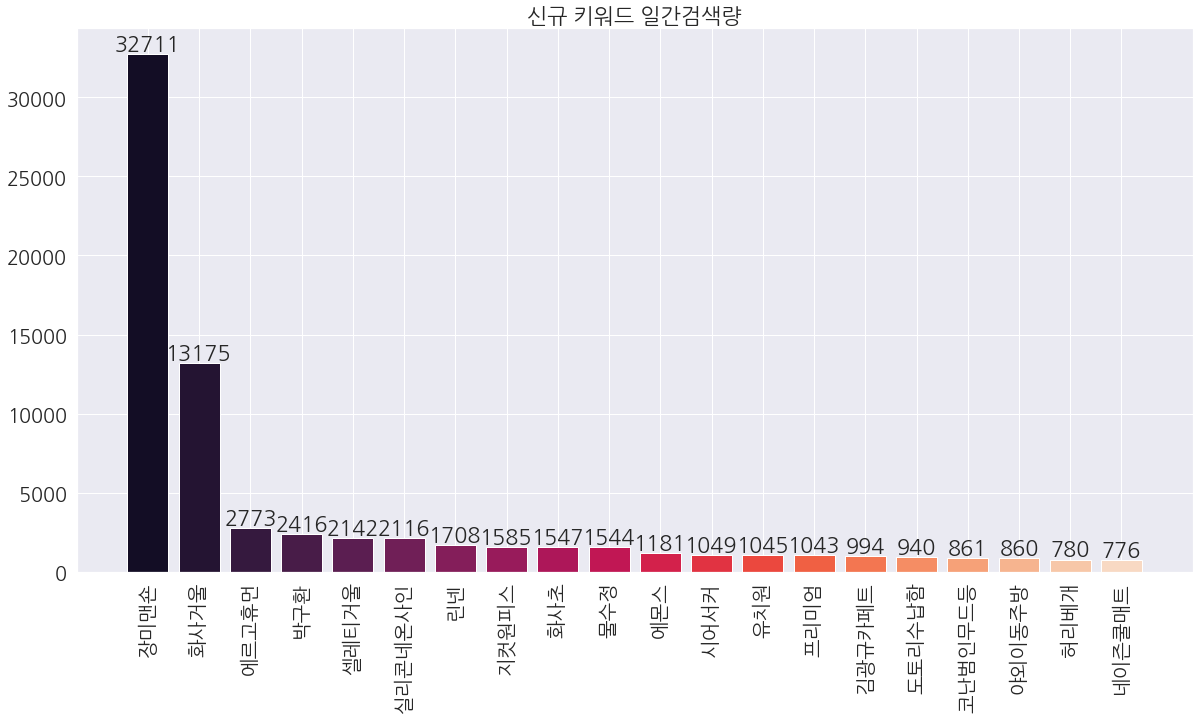

In [33]:
create_barplot('키워드', '일간검색량')

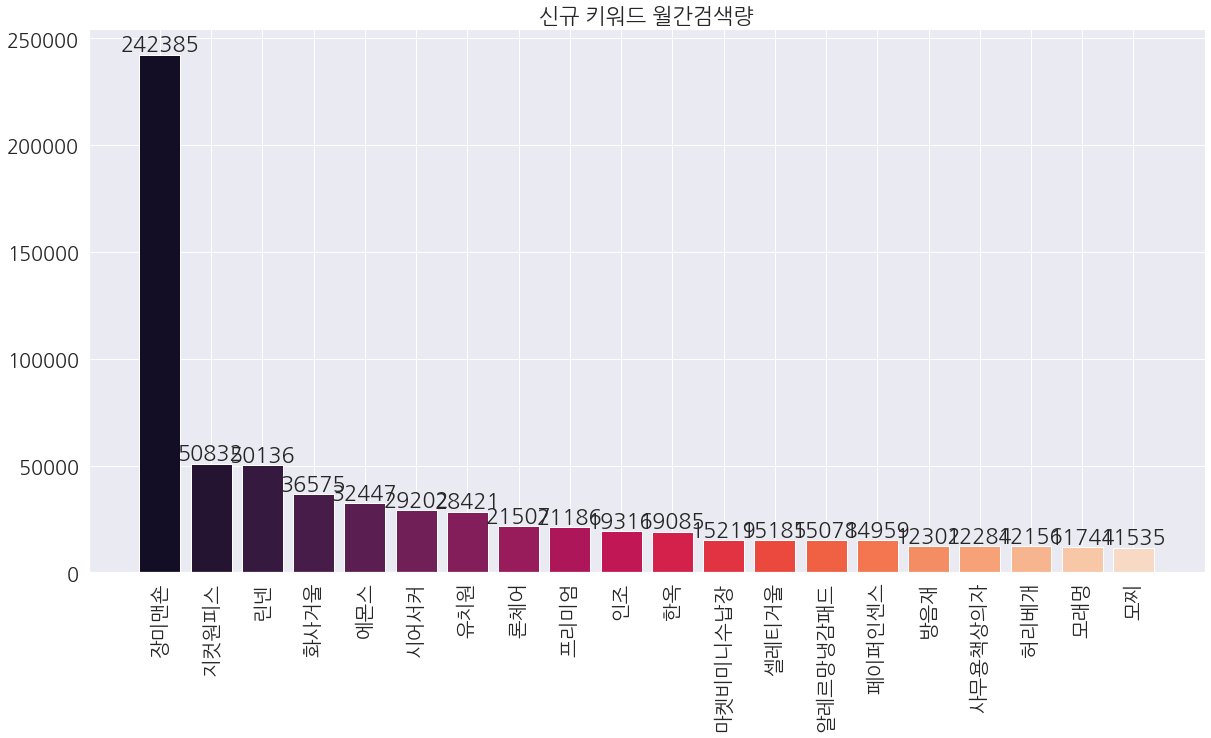

In [34]:
create_barplot('키워드', '월간검색량')

In [35]:
# heatplot() ; 단일 키워드 열지도 시각화
def heatplot():
    """
    키워드의 검색량을 볼 수 있는 시계열 열지도 생성 함수입니다.
    """
    
    print("### 조회 가능한 키워드 정보 ###")
    print("=" * 50)
    print(df_m[['등장일자','키워드']])
    
    # keyword = 조회할 키워드 입력
    keyword = input("검색량을 조회할 키워드 입력: ")
    
    # sns.heatmap
    # df_ym을 조회하려는 키워드의 검색량을 row = 월 / column = 년 으로 pivot 합니다.
    f, ax = plt.subplots(figsize=(16,10))
    sns.heatmap(df_ym.pivot("month", "year", keyword), cmap="YlGnBu",
               annot=True, annot_kws={"size": 15}, fmt='.1f', linewidths=.5, ax=ax)
    ax.set_title(keyword + ' 검색량')
    plt.savefig('C:/project/CODE/keyword/data/furniture/figs/' + yesterday + '_keyword_heatmap_chart.png', bbox_inches='tight')

### 조회 가능한 키워드 정보 ###
           등장일자         키워드
0    2022-05-10   헤링본규조토발매트
1    2022-05-10    방수가죽식탁매트
2    2022-05-11     빨아쓰는규조토
3    2022-05-11       욕실규조토
4    2022-05-11    마켓비주방수납장
..          ...         ...
156  2022-06-08         코지블
157  2022-06-08          모찌
158  2022-06-08  순면양면누빔베개커버
159  2022-06-08     네이즌여름매트
160  2022-06-08   접이식토퍼매트리스

[161 rows x 2 columns]
검색량을 조회할 키워드 입력: 화사거울


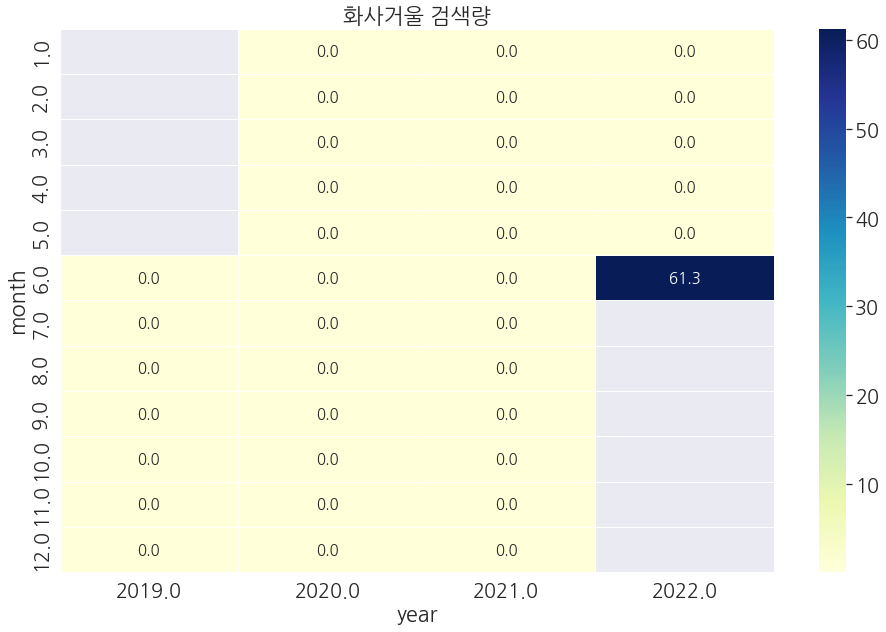

In [37]:
heatplot()

In [39]:
# heatplot_compare() ; 키워드 비교 열지도 시각화
def heatplot_compare():
    """
    '키워드1' vs '키워드2' 검색량을 비교해서 볼 수 있는 시계열 열지도 생성 함수입니다.
    """
    
    print("### 조회 가능한 키워드 정보 ###")
    print("=" * 50)
    print(df_m[['등장일자','키워드']])

    # keyword1, keyword2 = 조회할 키워드 입력
    keyword1 = input("검색량을 조회할 키워드1 입력 :")
    keyword2 = input("검색량을 조회할 키워드2 입력 :")
    
    # sns.heatmap
    # df_ym을 조회하려는 키워드의 검색량을 row = 월 / column = 년 으로 pivot 합니다.    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,10))
    sns.heatmap(df_ym.pivot("month", "year", keyword1), cmap="YlGnBu",
               annot=True, annot_kws={"size": 15}, fmt='.1f', linewidths=.5, ax=ax1)
    sns.heatmap(df_ym.pivot("month", "year", keyword2), cmap="YlGnBu",
               annot=True, annot_kws={"size": 15}, fmt='.1f', linewidths=.5, ax=ax2)
    ax1.set_title(keyword1 + " 검색량")
    ax2.set_title(keyword2 + " 검색량")
    plt.savefig('C:/project/CODE/keyword/data/furniture/figs/' + yesterday + 'keyword_compare_heatmap_chart.png', bbox_inches='tight')

### 조회 가능한 키워드 정보 ###
           등장일자         키워드
0    2022-05-10   헤링본규조토발매트
1    2022-05-10    방수가죽식탁매트
2    2022-05-11     빨아쓰는규조토
3    2022-05-11       욕실규조토
4    2022-05-11    마켓비주방수납장
..          ...         ...
156  2022-06-08         코지블
157  2022-06-08          모찌
158  2022-06-08  순면양면누빔베개커버
159  2022-06-08     네이즌여름매트
160  2022-06-08   접이식토퍼매트리스

[161 rows x 2 columns]
검색량을 조회할 키워드1 입력 :화사거울
검색량을 조회할 키워드2 입력 :페이퍼인센스


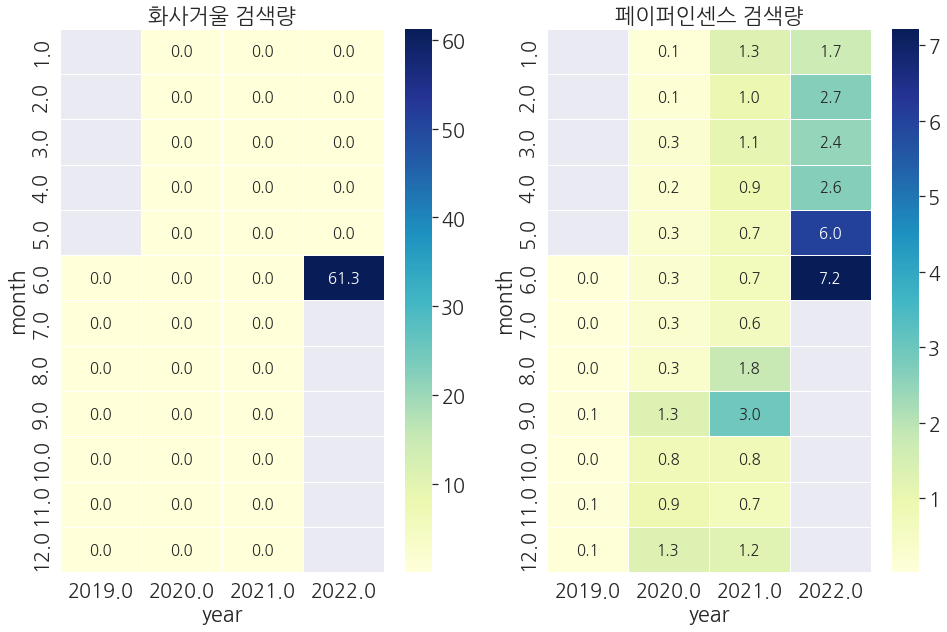

In [41]:
heatplot_compare()

In [103]:
# shapes
"""
1개월 이내 네이버 패션의류 탑 500 신규 진입 키워드들의 최근 1개월간 평균 검색량을 추출한 데이터프레임입니다.
"""
shapes = df_vis.copy()
shapes = shapes.truncate(before=time_month)
shapes = shapes.mean()
shapes = shapes.reset_index()
shapes.columns = ['keyword', 'month_avg_query']
shapes = shapes[:-2]
shapes = shapes.sort_values('month_avg_query', ascending=False).reset_index(drop=True)
shapes.head(20)

C:\Users\User\AppData\Local\Temp\ipykernel_20456\3092077136.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  shapes = shapes.mean()


,keyword,month_avg_query
0,리린,28.500079
1,김건희옷,15.449799
2,나이스,13.570576
3,운동화,13.052885
4,유니클로마르니,8.887810
5,마드제이,2.224100
6,디키즈874여자,1.889672
7,교련복,1.583467
8,폴로반팔셔츠,1.495555
9,셀린느티셔츠,1.452009


<AxesSubplot:title={'center':'최근 1개월 이내 네이버 패션의류 탑 500 신규 진입 키워드'}>

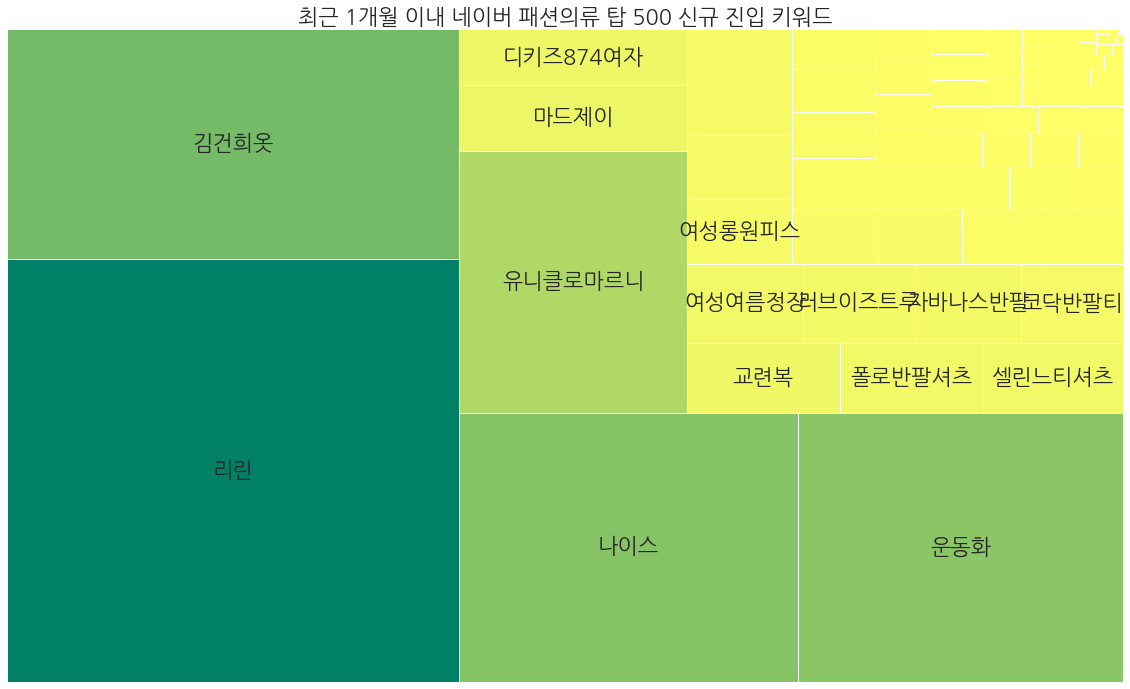

In [107]:
# 색상지도 시각화
cmap = matplotlib.cm.summer_r
norm = matplotlib.colors.Normalize(vmin=shapes.month_avg_query.min(), vmax=shapes.month_avg_query.max())
colors = [cmap(norm(value)) for value in shapes.month_avg_query]

# 연도별 블로그, 카페 건수 트리맵
plt.figure(figsize=(20,12)); plt.axis('off') ; plt.title("최근 1개월 이내 네이버 패션의류 탑 500 신규 진입 키워드")
squarify.plot(
    sizes=shapes.month_avg_query,
    color=colors,
    label=shapes.apply(lambda x: str(x.keyword) if x.month_avg_query >= 1 else '', axis=1),
    alpha=1)
